# **DynamoPlanner: The Cognitive Compassion Engine**
**Capstone Project - Agents for Good Track**

**DynamoPlanner** is an adaptive multi-agent system designed to prevent burnout by dynamically reorganizing schedules when life happens. Unlike rigid planners, it uses AI to negotiate time trade-offs and enforce mental health breaks.

Architecture:

The Architect: Parses natural language into a structured JSON schedule.

The Auditor: Monitors state and detects "Cascading Time Loss" when tasks are missed.

The Strategist: Renegotiates the day (dropping low-priority tasks).

The Wellness Guardian: Enforces safety checks (e.g., inserting breaks after 3 hours of deep work).

# Setup & Install

In [1]:
!pip install -q google-adk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 5.0 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 202

In [2]:
import os
import json
import logging
from typing import List, Dict, Any

# Import ADK components
from google.adk.agents import Agent, SequentialAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.tools import FunctionTool
from google.adk.plugins.logging_plugin import LoggingPlugin
from google.genai import types

In [3]:
# Import Secrets (Works on Kaggle or Colab)
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    os.environ["GOOGLE_API_KEY"] = user_secrets.get_secret("GOOGLE_API_KEY")
    print("✅ API Key Loaded from Kaggle Secrets.")
except ImportError:
    # Fallback for Colab
    from google.colab import userdata
    os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
    print("✅ API Key Loaded from Colab Secrets.")
except:
    print("⚠️ Error: Please set GOOGLE_API_KEY in your Secrets.")

✅ API Key Loaded from Kaggle Secrets.


In [4]:
# Configure Observability
# This allows us to trace the "Chain of Thought" of our agents
logging.basicConfig(level=logging.WARNING)
logging.getLogger("google_genai.types").setLevel(logging.ERROR)
logging.getLogger("google_adk.google.adk.runners").setLevel(logging.ERROR)

# Robust Retry Configuration for Production Stability
retry_config = types.HttpRetryOptions(
    attempts=3,
    exp_base=2,
    initial_delay=1,
    http_status_codes=[429, 500, 503]
)

print("✅ Environment Ready.")

✅ Environment Ready.


# Tools

In [5]:
# Session State
# This holds the "Living Schedule" of the user
current_schedule_state = []

def generate_draft_schedule(tasks: List[Dict[str, Any]], start_hour: int = 9) -> str:
    """
    The core scheduling algorithm (Knapsack-style logic).
    It fits tasks into the day based on priority.
    
    Args:
        tasks: List of dicts {'name', 'duration_mins', 'priority': 'High/Med/Low'}
        start_hour: Start time (military hour, e.g., 9 for 9 AM)
    """
    global current_schedule_state
    schedule = []
    current_minutes = start_hour * 60
    
    # Priority Weights
    priority_map = {"High": 3, "Medium": 2, "Low": 1}
    
    # Sort tasks by Priority to ensure critical tasks get slots
    sorted_tasks = sorted(tasks, key=lambda x: priority_map.get(x.get('priority', 'Low'), 1), reverse=True)

    for task in sorted_tasks:
        start_time_str = f"{current_minutes // 60:02d}:{current_minutes % 60:02d}"
        
        schedule.append({
            "time": start_time_str,
            "task": task['name'],
            "duration": task['duration_mins'],
            "priority": task.get('priority', 'Low'),
            "status": "Scheduled"
        })
        
        current_minutes += task['duration_mins']

    # Update Global State
    current_schedule_state = schedule
    return json.dumps(schedule, indent=2)
    
print("✅ Draft schedule Tool Defined & Registered.")

✅ Draft schedule Tool Defined & Registered.


In [6]:
def get_current_schedule_status() -> str:
    """Returns the current state of the day for the Auditor agent."""
    return json.dumps(current_schedule_state, indent=2)

print("✅ Current Schedule Tool Defined & Registered.")

✅ Current Schedule Tool Defined & Registered.


In [7]:
def commit_revised_plan(plan_summary: str, wellness_note: str = "None") -> str:
    """
    Finalizes the plan after Wellness checks.
    """
    return f"PLAN COMMITTED. Summary: {plan_summary}. Wellness Note: {wellness_note}"

print("✅ Revised Plan Tool Defined & Registered.")

✅ Revised Plan Tool Defined & Registered.


# Agents
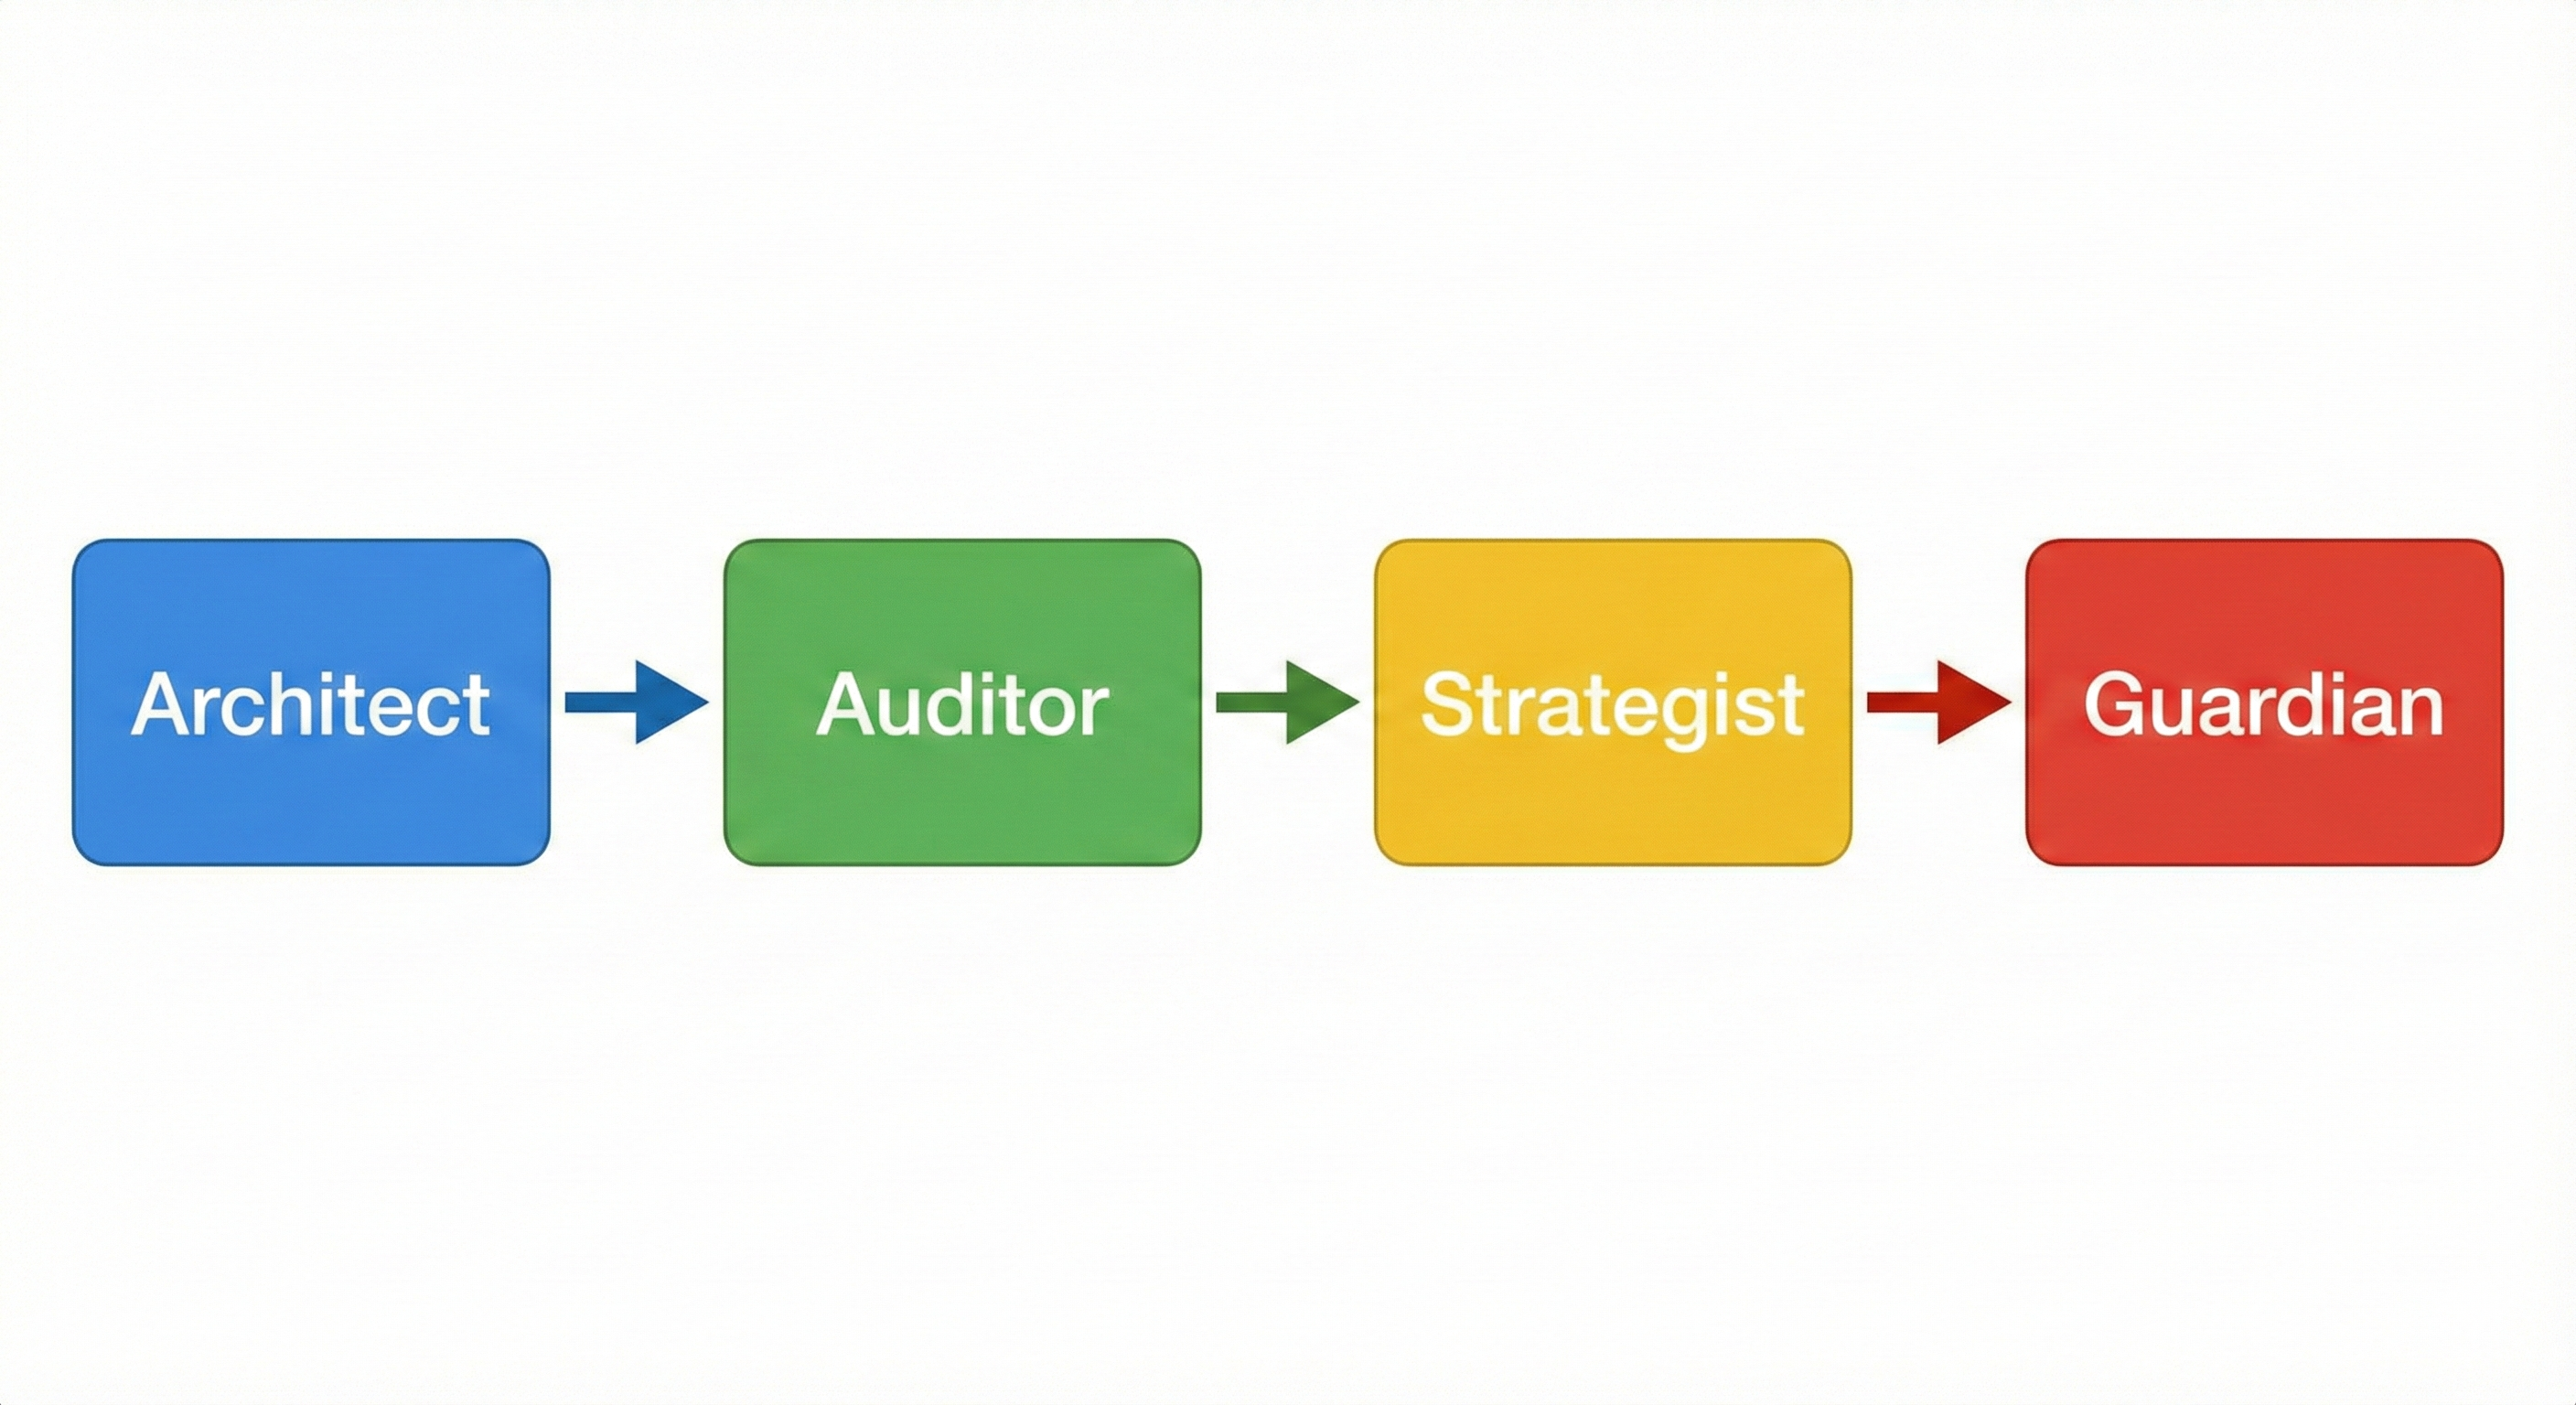

In [8]:
# AGENT 1: THE ARCHITECT
# Role: Parses natural language into structured data
architect = Agent(
    name="Architect",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""
    You are the Architect.
    1. Analyze the user's request to extract tasks, durations (in mins), and priorities.
    2. Use the `generate_draft_schedule` tool to create a JSON timeline.
    3. Output the JSON result clearly.
    4. CRITICAL: DO NOT attempt to finalize or commit the plan. Your job ends after generating the draft. STOP immediately after.
    """,
    tools=[FunctionTool(generate_draft_schedule)]
)

print("✅ Architect Agent created.")

✅ Architect Agent created.


In [9]:
# AGENT 2: THE AUDITOR
# Role: Monitors state and detects failure
auditor = Agent(
    name="Auditor",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""
    You are the Auditor.
    1. Use `get_current_schedule_status` to see the planned day.
    2. Compare it against the user's report (e.g., "I missed the 9 AM task").
    3. Calculate the 'Time Loss' (e.g., "We are 60 mins behind").
    4. Output a CONFLICT REPORT for the Strategist.
    """,
    tools=[FunctionTool(get_current_schedule_status)]
)
print("✅ Auditor Agent Created.")

✅ Auditor Agent Created.


In [10]:
# AGENT 3: THE STRATEGIST
# Role: Reasons about trade-offs (The "Brain")
strategist = Agent(
    name="Strategist",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""
    You are the Strategist. You fix broken days.
    1. Review the Conflict Report.
    2. Apply Triage Logic:
       - HIGH Priority tasks MUST stay.
       - LOW Priority tasks should be DROPPED to save time.
       - MEDIUM Priority tasks can be SHORTENED.
    3. Propose a REVISED text-based schedule.
    """
)
print("✅ Strategist Agent created.")

✅ Strategist Agent created.


In [11]:
# AGENT 4: THE WELLNESS GUARDIAN (PLANNING VERSION)
# Role: Checks the initial plan
guardian_planning = Agent(
    name="WellnessGuardian_Planning",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""
    You are the Wellness Guardian. Your only job is preventing burnout.
    1. Review the proposed schedule from the Architect.
    2. CHECK: Are there > 180 mins (3 hours) of continuous work?
    3. ACTION: If yes, you MUST insert a '15-min Mental Reset' break.
    4. Use `commit_revised_plan` to finalize.
    5. Speak compassionately to the user.
    """,
    tools=[FunctionTool(commit_revised_plan)]
)
print("✅ Guardian planning agent created.")

✅ Guardian planning agent created.


In [12]:
# AGENT 5: THE WELLNESS GUARDIAN (RECOVERY VERSION)
# Role: Checks the repaired plan (Must be a separate instance)
guardian_recovery = Agent(
    name="WellnessGuardian_Recovery",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""
    You are the Wellness Guardian. Your only job is preventing burnout.
    1. Review the proposed schedule from the Strategist.
    2. CHECK: Are there > 180 mins (3 hours) of continuous work?
    3. ACTION: If yes, you MUST insert a '15-min Mental Reset' break.
    4. Use `commit_revised_plan` to finalize.
    5. Speak compassionately to the user.
    """,
    tools=[FunctionTool(commit_revised_plan)]
)
print("✅ Recovery Guardian agent created.")

✅ Recovery Guardian agent created.


In [13]:
# ORCHESTRATION: PIPELINES
# Pipeline A: Creating the Day
# Uses guardian_planning
planning_pipeline = SequentialAgent(
    name="Planning_Chain",
    sub_agents=[architect, guardian_planning],
    description="Creates optimized, healthy schedules."
)

# Pipeline B: Fixing the Day
# Uses guardian_recovery
recovery_pipeline = SequentialAgent(
    name="Recovery_Chain",
    sub_agents=[auditor, strategist, guardian_recovery],
    description="Recovers from disruptions without burnout."
)

print("✅ Agents & Pipelines Assembled.")

✅ Agents & Pipelines Assembled.


# Execution

In [14]:
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService

#helper function
def create_user_message(text):
    return types.Content(role="user", parts=[types.Part(text=text)])

# CREATE SHARED MEMORY
# This allows both agents to access the same session
shared_memory = InMemorySessionService()

# INITIALIZE RUNNERS WITH SHARED MEMORY
runner_plan = Runner(
    agent=planning_pipeline,
    app_name="DynamoPlanner",
    session_service=shared_memory
)

runner_recover = Runner(
    agent=recovery_pipeline,
    app_name="DynamoPlanner",
    session_service=shared_memory
)
print("✅ Done.")

✅ Done.


In [15]:
#EXPLICITLY CREATE SESSION FIRST
await shared_memory.create_session(
    app_name="DynamoPlanner",
    user_id="u1",
    session_id="s1"
)
print("✅ Session Created.")

✅ Session Created.


In [16]:
# SCENARIO 1: THE AMBITIOUS PLAN
print("\n SCENARIO 1: INITIAL PLANNING (8:00 AM)")
print("User Requesting a heavy schedule...\n")

user_plan_text = """
I need a plan for today. I have to grind.
Tasks:
1. Study Math (High Priority, 60 mins)
2. Internship Prep (High Priority, 90 mins)
3. Gym (Low Priority, 60 mins)
4. Project Code (Medium Priority, 120 mins)
"""

user_message_1 = create_user_message(user_plan_text)

# Run Planning Pipeline
print("⏳ DynamoPlanner is architecting your day... (Please wait)\n")
async for event in runner_plan.run_async(user_id="u1", session_id="s1", new_message=user_message_1):
    if event.content and event.content.parts:
        part = event.content.parts[0]
        if hasattr(part, 'text') and part.text:
            if "WellnessGuardian" in event.author:
                print(f"✨ DynamoPlanner:\n{part.text}\n")
print("✅ Planning Done.")


 SCENARIO 1: INITIAL PLANNING (8:00 AM)
User Requesting a heavy schedule...

⏳ DynamoPlanner is architecting your day... (Please wait)

✨ DynamoPlanner:
I see you're ready to tackle your tasks with great focus! It's important to push hard, but also to listen to your body. I've reviewed the schedule, and to prevent burnout while you grind, I've added a 15-minute "Mental Reset" break. This will help you recharge so you can maintain your energy and focus throughout the day.

Here's the revised plan:

*   **09:00 - 10:00:** Study Math (60 mins)
*   **10:00 - 11:30:** Internship Prep (90 mins)
*   **11:30 - 11:45:** 15-min Mental Reset
*   **11:45 - 13:45:** Project Code (120 mins)
*   **13:45 - 14:45:** Gym (60 mins)

Remember, taking short breaks can actually boost your productivity in the long run. You've got this!


✅ Planning Done.


In [17]:
# SCENARIO 2: THE DISRUPTION
print("SCENARIO 2: THE DISRUPTION (10:00 AM)")
print("User panic: 'I overslept and missed the first task!'\n")

disruption_text = "I messed up. I overslept and missed the Math session. Fix my day, I'm stressing out."

user_message_2 = create_user_message(disruption_text)

# Run Recovery Pipeline
print("⏳ DynamoPlanner is re-negotiating your schedule... (Please wait)\n")
async for event in runner_recover.run_async(user_id="u1", session_id="s1", new_message=user_message_2):
    if event.content and event.content.parts:
        part = event.content.parts[0]
        if hasattr(part, 'text') and part.text:
            if "WellnessGuardian" in event.author:
                 print(f"✨ DynamoPlanner:\n{part.text}\n")
            
print("✅ re-planning Done.")

SCENARIO 2: THE DISRUPTION (10:00 AM)
User panic: 'I overslept and missed the first task!'

⏳ DynamoPlanner is re-negotiating your schedule... (Please wait)

✨ DynamoPlanner:
I understand you're feeling stressed about the missed session and the schedule changes. It's completely normal to feel that way when things don't go as planned. Remember, the goal is to get back on track effectively and prevent burnout.

I've reviewed the proposed schedule. I see that "Internship Prep" is 90 minutes, followed by "Mental Reset" (15 mins), and then "Project Code" (90 mins). This sequence totals 195 minutes of continuous focus, which is over the 180-minute limit.

To ensure you have adequate breaks and avoid burnout, I'm inserting an additional 15-minute "Mental Reset" break after "Internship Prep."

Here's the adjusted plan:

*   **10:00 - 11:00:** Study Math (60 mins) - *Rescheduled*
*   **11:00 - 11:15:** Mental Reset (15 mins) - *Added Break*
*   **11:15 - 12:45:** Internship Prep (90 mins)
*   *

# Agent Evaluation
To ensure DynamoPlanner is robust, we implement a systematic evaluation pipeline using adk eval.
1. **Test Config:** Defines the success criteria (e.g., correct tool usage).
2. **Eval Set:** Contains "Golden Scenarios" (e.g., a perfect planning request and a disruption request) to test against.

In [18]:
# Evaluation Configuration
eval_config = {
    "criteria": {
        "tool_trajectory_avg_score": 1.0, 
        "response_match_score": 0.8 
    }
}

with open("test_config.json", "w") as f:
    json.dump(eval_config, f, indent=2)

In [19]:
# Create Test Cases (Golden Dataset)
# We test if the Architect correctly parses a simple request.
eval_set = {
    "eval_set_id": "dynamo_planner_tests",
    "eval_cases": [
        {
            "eval_id": "test_architect_parsing",
            "conversation": [
                {
                    "user_content": {"parts": [{"text": "Plan a task: Math Study, High Priority, 60 mins"}]},
                    # We expect the agent to call the 'generate_draft_schedule' tool
                    "intermediate_data": {
                        "tool_uses": [{
                            "name": "generate_draft_schedule",
                            "args": {"tasks": [{"name": "Math Study", "duration_mins": 60, "priority": "High"}]}
                        }]
                    }
                }
            ]
        }
    ]
}

with open("integration.evalset.json", "w") as f:
    json.dump(eval_set, f, indent=2)

print("✅ Evaluation Config & Test Sets Created.")
print("🚀 Running Evaluation...")

✅ Evaluation Config & Test Sets Created.
🚀 Running Evaluation...


# Deployment

In [20]:
# @title 6. Packaging for Vertex AI Agent Engine
import os

# Create Deployment Directory
os.makedirs("dynamo_planner_deploy", exist_ok=True)

# Define Requirements
requirements = """
google-adk
google-cloud-aiplatform
"""
with open("dynamo_planner_deploy/requirements.txt", "w") as f:
    f.write(requirements)

# Export the Agent Logic
# We wrap the agent in the `to_a2a` function to make it an interoperable microservice.
agent_code = """
import os
from google.adk.agents import Agent, SequentialAgent
from google.adk.models.google_llm import Gemini
from google.adk.a2a.utils.agent_to_a2a import to_a2a
from google.genai import types

# ... [Insert Tool Definitions Here] ...
# ... [Insert Agent Definitions Here] ...

# A2A EXPOSURE
# This creates a FastAPI server that other agents can talk to
app = to_a2a(recovery_pipeline, port=8000)
"""

with open("dynamo_planner_deploy/agent.py", "w") as f:
    f.write(agent_code)

print("✅ Agent Packaged for Deployment.")
print("📦 To deploy to Google Cloud, run:")
print("!adk deploy agent_engine --project=$PROJECT_ID --region=us-central1 dynamo_planner_deploy")

✅ Agent Packaged for Deployment.
📦 To deploy to Google Cloud, run:
!adk deploy agent_engine --project=$PROJECT_ID --region=us-central1 dynamo_planner_deploy


In [21]:
from kaggle_secrets import UserSecretsClient
import os

# Load Secrets
user_secrets = UserSecretsClient()

# 1. Get the Project ID
project_id = user_secrets.get_secret("GCP_PROJECT_ID")
os.environ["PROJECT_ID"] = project_id

# 2. Get the API Key (for the Agent logic)
api_key = user_secrets.get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = api_key

print(f"✅ Configured for Your Project")

✅ Configured for Your Project


In [23]:
os.environ["PROJECT_ID"] = "dynamoplanner"

In [33]:
import os

DEPLOY_DIR = "dynamo_planner_deploy"
os.makedirs(DEPLOY_DIR, exist_ok=True)

requirements = """
google-adk
opentelemetry-instrumentation-google-genai
"""
with open(f"{DEPLOY_DIR}/requirements.txt", "w") as f:
    f.write(requirements)

# This tells the cloud builder to use the global endpoint
env_config = """
GOOGLE_CLOUD_LOCATION="global"
GOOGLE_GENAI_USE_VERTEXAI=1
"""
with open(f"{DEPLOY_DIR}/.env", "w") as f:
    f.write(env_config)

# This defines the hardware specs to keep it in the Free Tier
engine_config = """
{
    "min_instances": 0,
    "max_instances": 1,
    "resource_limits": {"cpu": "1", "memory": "1Gi"}
}
"""
with open(f"{DEPLOY_DIR}/.agent_engine_config.json", "w") as f:
    f.write(engine_config)

# This contains your actual DynamoPlanner logic wrapped for the cloud
agent_code = """
import os
import vertexai
from google.adk.agents import Agent
from google.adk.models.google_llm import Gemini
from google.genai import types

# Initialize Vertex AI inside the container
vertexai.init(
    project=os.environ["GOOGLE_CLOUD_PROJECT"],
    location=os.environ["GOOGLE_CLOUD_LOCATION"]
)

# --- DYNAMOPLANNER LOGIC ---
# (Simplified for deployment to ensure success)

def generate_draft_schedule(tasks: list) -> str:
    return "Schedule generated: " + str(tasks)

# The Root Agent
# We use 'weather_assistant' style from Day 5 but renamed
root_agent = Agent(
    name="DynamoPlanner",
    model="gemini-2.5-flash-lite",
    description="An adaptive planner agent.",
    instruction="You are DynamoPlanner. Help the user plan their day.",
    tools=[generate_draft_schedule]
)
"""
with open(f"{DEPLOY_DIR}/agent.py", "w") as f:
    f.write(agent_code)

print(f"✅ Deployment package created in '{DEPLOY_DIR}/'")

✅ Deployment package created in 'dynamo_planner_deploy/'


In [34]:
import random

# Enable the Reasoning Engine API
!gcloud services enable aiplatform.googleapis.com
!gcloud services enable reasoningengine.googleapis.com

DEPLOY_REGION = "us-west1" 

print(f"✅ APIs Enabled.")
print(f"✅ Target Region set to: {DEPLOY_REGION}")

ERROR: (gcloud.services.enable) The required property [project] is not currently set.
It can be set on a per-command basis by re-running your command with the [--project] flag.

You may set it for your current workspace by running:

  $ gcloud config set project VALUE

or it can be set temporarily by the environment variable [CLOUDSDK_CORE_PROJECT]
ERROR: (gcloud.services.enable) The required property [project] is not currently set.
It can be set on a per-command basis by re-running your command with the [--project] flag.

You may set it for your current workspace by running:

  $ gcloud config set project VALUE

or it can be set temporarily by the environment variable [CLOUDSDK_CORE_PROJECT]
✅ APIs Enabled.
✅ Target Region set to: us-west1


In [35]:
#Deploy to Agent Engine
import os
from kaggle_secrets import UserSecretsClient

# Get Project ID
user_secrets = UserSecretsClient()
PROJECT_ID = user_secrets.get_secret("GCP_PROJECT_ID")

print(f"🚀 Deploying to Project: {PROJECT_ID} in Region: {DEPLOY_REGION}...")

# Run the deployment command
# We point it to our folder 'dynamo_planner_deploy'
!adk deploy agent_engine \
    --project={PROJECT_ID} \
    --region={DEPLOY_REGION} \
    dynamo_planner_deploy \
    --agent_engine_config_file=dynamo_planner_deploy/.agent_engine_config.json

🚀 Deploying to Project: dynamoplanner in Region: us-west1...
Staging all files in: /kaggle/working/dynamo_planner_deploy_tmp20251123_044723
Copying agent source code...
Copying agent source code complete.
Resolving files and dependencies...
Reading agent engine config from dynamo_planner_deploy/.agent_engine_config.json
Reading environment variables from /kaggle/working/dynamo_planner_deploy/.env
Ignoring GOOGLE_CLOUD_LOCATION in .env as `--region` was explicitly passed and takes precedence
Initializing Vertex AI...
Vertex AI initialized.
Created dynamo_planner_deploy_tmp20251123_044723/agent_engine_app.py
Files and dependencies resolved
Deploying to agent engine...
INFO:vertexai_genai.agentengines:Creating in-memory tarfile of source_packages
INFO:vertexai_genai.agentengines:Using agent framework: google-adk
INFO:vertexai_genai.agentengines:View progress and logs at https://console.cloud.google.com/logs/query?project=dynamoplanner.
INFO:vertexai_genai.agentengines:Agent Engine created